<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/16_Training_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
#hide
from fastbook import *

# The Training Process

The basis of stochastic gradient descent: pass a mini-batch to the model, compare it to our target with the loss function, then compute the gradients of this loss function with regard to each weight before updating the weights with the formula:

 ***new_weight = weight - lr * weight.grad***


PyTorch provides a simple nn.SGD class that does this calculation for each parameter for us. In this chapter we will build some faster optimizers, using a flexible foundation. But that's not all we might want to change in the training process. For any tweak of the training loop, we will need a way to add some code to the basis of SGD. The fastai library has a system of callbacks to do this, and we will teach you all about it.

Let's start with standard SGD to get a baseline, then we will introduce the most commonly used optimizers.

# Establishing a Baseline

First, we'll create a baseline, using plain SGD, and compare it to fastai's default optimizer. We'll start by grabbing ImageWoof with the same get_data

In [ ]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
        splitter=GrandparentSplitter(valid_name='val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize),
                    Normalize.from_stats(*imagenet_stats)],
    ).dataloaders(path, bs=128)

In [ ]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

We'll create a ResNet-34 without pretraining, and pass along any arguments received:

In [ ]:
def get_learner(**kwargs):
    return vision_learner(dls, resnet34, pretrained=False,
                    metrics=accuracy, **kwargs).to_fp16()

In [ ]:
learn = get_learner(opt_func=SGD)

In [ ]:
learn.lr_find()

In [49]:
learn.fit(100, 0.007)

epoch,train_loss,valid_loss,accuracy,time
0,3.698961,3.422382,0.099262,00:09
1,3.660587,3.324889,0.095444,00:09
2,3.659592,3.295699,0.094681,00:08
3,3.645469,3.405234,0.091117,00:09
4,3.613143,3.370984,0.090354,00:08
5,3.598566,3.307530,0.100025,00:08
6,3.566361,3.302493,0.101298,00:08
7,3.566561,3.123950,0.102571,00:08
8,3.558650,3.216032,0.097989,00:08
9,3.562200,3.122907,0.104607,00:08


epoch,train_loss,valid_loss,accuracy,time
0,3.698961,3.422382,0.099262,00:09
1,3.660587,3.324889,0.095444,00:09
2,3.659592,3.295699,0.094681,00:08
3,3.645469,3.405234,0.091117,00:09
4,3.613143,3.370984,0.090354,00:08
5,3.598566,3.307530,0.100025,00:08
6,3.566361,3.302493,0.101298,00:08
7,3.566561,3.123950,0.102571,00:08
8,3.558650,3.216032,0.097989,00:08
9,3.562200,3.122907,0.104607,00:08


KeyboardInterrupt: ignored

Clearly, plain SGD isn't training as fast as we'd like. So let's learn some tricks to get accelerated training!

# A Generic Optimizer

To build up our accelerated SGD tricks, we'll need to start with a nice flexible optimizer foundation. No library prior to fastai provided such a foundation, but during fastai's development we realized that all the optimizer improvements we'd seen in the academic literature could be handled using optimizer callbacks. These are small pieces of code that we can compose, mix and match in an optimizer to build the optimizer step. They are called by fastai's lightweight Optimizer class. These are the definitions in Optimizer of the two key methods that we've been using in this book:

In [ ]:
def zero_grad(self):
    for p,*_ in self.all_params():
        p.grad.detach_()
        p.grad.zero_()

def step(self):
    for p,pg,state,hyper in self.all_params():
        for cb in self.cbs:
            state = _update(state, cb(p, **{**state, **hyper}))
        self.state[p] = state

As we saw when training an MNIST model from scratch, zero_grad just loops through the parameters of the model and sets the gradients to zero. It also calls detach_, which removes any history of gradient computation, since it won't be needed after zero_grad.

The more interesting method is step, which loops through the callbacks (cbs) and calls them to update the parameters (the _update function just calls state.update if there's anything returned by cb). As you can see, Optimizer doesn't actually do any SGD steps itself. Let's see how we can add SGD to Optimizer.

Here's an optimizer callback that does a single SGD step, by multiplying -lr by the gradients and adding that to the parameter (when Tensor.add_ in PyTorch is passed two parameters, they are multiplied together before the addition):

In [ ]:
def sgd_cb(p, lr, **kwargs): p.data.add_(-lr, p.grad.data)

We can pass this to Optimizer using the cbs parameter; we'll need to use partial since Learner will call this function to create our optimizer later:

In [ ]:
opt_func = partial(Optimizer, cbs=[sgd_cb])

In [ ]:
learn = get_learner(opt_func=opt_func)
learn.fit(100, 0.007)

It's working! So that's how we create SGD from scratch in fastai. Now let's see what "momentum" is.

# Momentum

SGD can be thought of as standing at the top of a mountain and working your way down by taking a step in the direction of the steepest slope at each point in time. But what if we have a ball rolling down the mountain? It won't, at each given point, exactly follow the direction of the gradient, as it will have momentum. A ball with more momentum (for instance, a heavier ball) will skip over little bumps and holes, and be more likely to get to the bottom of a bumpy mountain. A ping pong ball, on the other hand, will get stuck in every little crevice.

So how can we bring this idea over to SGD? We can use a moving average, instead of only the current gradient, to make our step:


```
weight.avg = beta * weight.avg + (1-beta) * weight.grad
new_weight = weight - lr * weight.avg
```
Here beta is some number we choose which defines how much momentum to use. If beta is 0, then the first equation becomes weight.avg = weight.grad, so we end up with plain SGD. But if it's a number close to 1, then the main direction chosen is an average of the previous steps. 

Note that we are writing weight.avg to highlight the fact that we need to store the moving averages for each parameter of the model (they all have their own independent moving averages).


**Momentum** works particularly well if the loss function has narrow canyons we need to navigate: vanilla SGD would send us bouncing from one side to the other, while SGD with momentum will average those to roll smoothly down the side. The parameter beta determines the strength of the momentum we are using: with a small beta we stay closer to the actual gradient values, whereas with a high beta we will mostly go in the direction of the average of the gradients and it will take a while before any change in the gradients makes that trend move.

With a large beta, we might miss that the gradients have changed directions and roll over a small local minima. This is a desired side effect: intuitively, when we show a new input to our model, it will look like something in the training set but won't be exactly like it. That means it will correspond to a point in the loss function that is close to the minimum we ended up with at the end of training, but not exactly at that minimum. So, we would rather end up training in a wide minimum, where nearby points have approximately the same loss (or if you prefer, a point where the loss is as flat as possible).

In SGD with momentum, a value of beta that is often used is 0.9.

fit_one_cycle by default starts with a beta of 0.95, gradually adjusts it to 0.85, and then gradually moves it back to 0.95 at the end of training. Let's see how our training goes with momentum added to plain SGD.

In order to add momentum to our optimizer, we'll first need to keep track of the moving average gradient, which we can do with another callback. When an optimizer callback returns a dict, it is used to update the state of the optimizer and is passed back to the optimizer on the next step. So this callback will keep track of the gradient averages in a parameter called grad_avg:

In [ ]:
def average_grad(p, mom, grad_avg=None, **kwargs):
    if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
    return {'grad_avg': grad_avg*mom + p.grad.data}

To use it, we just have to replace p.grad.data with grad_avg in our step function:

In [ ]:
def momentum_step(p, lr, grad_avg, **kwargs): p.data.add_(-lr, grad_avg)

In [ ]:
opt_func = partial(Optimizer, cbs=[average_grad,momentum_step], mom=0.9)

Learner will automatically schedule mom and lr, so fit_one_cycle will even work with our custom Optimizer:

In [ ]:
learn = get_learner(opt_func=opt_func)
learn.fit(100, 0.007)

# RMSProp

The main difference from SGD is that it uses an adaptive learning rate: instead of using the same learning rate for every parameter, each parameter gets its own specific learning rate controlled by a global learning rate. That way we can speed up training by giving a higher learning rate to the weights that need to change a lot while the ones that are good enough get a lower learning rate.

How do we decide which parameters should have a high learning rate and which should not? We can look at the gradients to get an idea. If a parameter's gradients have been close to zero for a while, that parameter will need a higher learning rate because the loss is flat. On the other hand, if the gradients are all over the place, we should probably be careful and pick a low learning rate to avoid divergence. We can't just average the gradients to see if they're changing a lot, because the average of a large positive and a large negative number is close to zero. Instead, we can use the usual trick of either taking the absolute value or the squared values (and then taking the square root after the mean).

Once again, to determine the general tendency behind the noise, we will use a moving average—specifically the moving average of the gradients squared. Then we will update the corresponding weight by using the current gradient (for the direction) divided by the square root of this moving average (that way if it's low, the effective learning rate will be higher, and if it's high, the effective learning rate will be lower):



```
w.square_avg = alpha * w.square_avg + (1-alpha) * (w.grad ** 2)
new_w = w - lr * w.grad / math.sqrt(w.square_avg + eps)
```



The eps (epsilon) is added for numerical stability (usually set at 1e-8), and the default value for alpha is usually 0.99.

We can add this to Optimizer by doing much the same thing we did for avg_grad, but with an extra **2

In [ ]:
def average_sqr_grad(p, sqr_mom, sqr_avg=None, **kwargs):
    if sqr_avg is None: sqr_avg = torch.zeros_like(p.grad.data)
    return {'sqr_avg': sqr_mom*sqr_avg + (1-sqr_mom)*p.grad.data**2}

And we can define our step function and optimizer as before:

In [ ]:
def rms_prop_step(p, lr, sqr_avg, eps, grad_avg=None, **kwargs):
    denom = sqr_avg.sqrt().add_(eps)
    p.data.addcdiv_(-lr, p.grad, denom)

opt_func = partial(Optimizer, cbs=[average_sqr_grad,rms_prop_step],
                   sqr_mom=0.99, eps=1e-7)

In [ ]:
learn = get_learner(opt_func=opt_func)
learn.fit(100, 0.007)

In [ ]:
learn.recorder.plot_loss()

We just have to bring these ideas together, and we have Adam, fastai's default optimizer.

# Adam

Adam mixes the ideas of SGD with momentum and RMSProp together: it uses the moving average of the gradients as a direction and divides by the square root of the moving average of the gradients squared to give an adaptive learning rate to each parameter.

There is one other difference in how Adam calculates moving averages. It takes the unbiased moving average, which is:


```
w.avg = beta * w.avg + (1-beta) * w.grad
unbias_avg = w.avg / (1 - (beta**(i+1)))

```


if we are the i-th iteration (starting at 0 like Python does). This divisor of 1 - (beta**(i+1)) makes sure the unbiased average looks more like the gradients at the beginning (since beta < 1, the denominator is very quickly close to 1).

Putting everything together, our update step looks like:



```
w.avg = beta1 * w.avg + (1-beta1) * w.grad
unbias_avg = w.avg / (1 - (beta1**(i+1)))
w.sqr_avg = beta2 * w.sqr_avg + (1-beta2) * (w.grad ** 2)
new_w = w - lr * unbias_avg / sqrt(w.sqr_avg + eps)
```



Like for RMSProp, eps is usually set to 1e-8, and the default for (beta1,beta2) suggested by the literature is (0.9,0.999).

In fastai, Adam is the default optimizer we use since it allows faster training, but we've found that beta2=0.99 is better suited to the type of schedule we are using. beta1 is the momentum parameter, which we specify with the argument moms in our call to fit_one_cycle. As for eps, fastai uses a default of 1e-5. eps is not just useful for numerical stability. A higher eps limits the maximum value of the adjusted learning rate. To take an extreme example, if eps is 1, then the adjusted learning will never be higher than the base learning rate.

One thing that changes when we go from SGD to Adam is the way we apply weight decay, and it can have important consequences.

In [ ]:
opta = partial(Adam)
learn = get_learner(opt_func=opta)
learn.fit(100, 0.007)

# Decoupled Weight Decay

Weight decay,is equivalent to (in the case of vanilla SGD) updating the parameters with:


```
new_weight = weight - lr*weight.grad - lr*wd*weight
```

The last part of this formula explains the name of this technique: each weight is decayed by a factor lr * wd.

The other name of weight decay is L2 regularization, which consists in adding the sum of all squared weights to the loss (multiplied by the weight decay)

This can be directly expressed on the gradients with:

```
weight.grad += wd*weight
```

For SGD, those two formulas are equivalent. However, this equivalence only holds for standard SGD, because we have seen that with momentum, RMSProp or in Adam, the update has some additional formulas around the gradient.

Most libraries use the second formulation, but it was pointed out in "Decoupled Weight Decay Regularization" by Ilya Loshchilov and Frank Hutter, that the first one is the only correct approach with the Adam optimizer or momentum, which is why fastai makes it its default.

# Radam

A [paper](https://arxiv.org/pdf/1908.03265.pdf) by Liu, Jian, He et al introduces RAdam, or “Rectified Adam”. It’s a new variation of the classic Adam optimizer that provides an automated, dynamic adjustment to the adaptive learning rate based on their detailed study into the effects of variance and momentum during training. RAdam holds the promise of immediately improving every AI architecture compared to vanilla Adam.

Let’s delve into RAdam and understand what it does internally, and why it holds the promise of delivering improved convergence, better training stability (much less sensitive to chosen learning rates) and better accuracy and generalization for nearly all AI applications.

The authors note that while everyone is working towards the goal of having fast and stable optimization algorithms, adaptive learning rate optimizers including Adam, RMSProp, etc. all suffer from a risk of converging into poor local optima — if a warm-up method is not implemented. Thus, nearly everyone uses some form of warmup (FastAI has a built in warmup in it’s Fit_One_Cycle)…but why is a warmup needed?

With the current limited understanding of the underlying reason or even best practices to the warmup heuristic in the AI community, the authors sought to uncover the underpinnings for this issue. They find that the root issue is that adaptive learning rate optimizers have too large of a variance, especially in the early stages of training, and make excessive jumps based on limited training data…and thus can settle into poor local optima.

Hence, warmup (an initial period of training with a much lower learning rate) is a requirement for adaptive optimizers to offset excessive variance when the optimizer has only worked with limited training data.

In short, vanilla Adam and other adaptive learning rate optimizers make bad decisions based on too little data early on in training. Thus, without some form of warmup, they are likely to initially fall into bad local optima making the training curve longer and harder due to a bad start.

The authors then tested running Adam with no warmup, but avoiding any use of momentum for the first 2000 iterations (adam-2k). They found that similar results as Adam plus warmup were achieved, thus verifying that warm-up functions as a ‘variance reduction’ during initial training and avoids Adam jumping into bad optima at the start when it does not have enough data to work with.

Given that warm-up serves as a variance reducer, but the degree of warmup required is unknown and varies dataset to dataset, the authors then moved into determining a mathematical algorithm to serve as a dynamic variance reducer. They thus built a rectifier term, that would allow the adaptive momentum to slowly but steadily be allowed to work up to full expression as a function of the underlying variance.

In [ ]:
optar = partial(RAdam)
learn = get_learner(opt_func=optar)
learn.fit(100, 0.007)

# Callbacks

Sometimes you need to change how things work a little bit. In fact, we have already seen examples of this: Mixup, fp16 training, resetting the model after each epoch for training RNNs, and so forth. How do we go about making these kinds of tweaks to the training process?

We've seen the basic training loop, which, with the help of the Optimizer class, looks like this for a single epoch:



```
for xb,yb in dl:
    loss = loss_func(model(xb), yb)
    loss.backward()
    opt.step()
    opt.zero_grad()
```



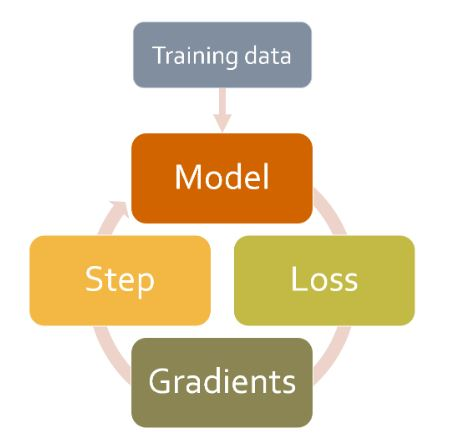

The usual way for deep learning practitioners to customize the training loop is to make a copy of an existing training loop, and then insert the code necessary for their particular changes into it. This is how nearly all code that you find online will look. But it has some very serious problems.

It's not very likely that some particular tweaked training loop is going to meet your particular needs. There are hundreds of changes that can be made to a training loop, which means there are billions and billions of possible permutations. You can't just copy one tweak from a training loop here, another from a training loop there, and expect them all to work together. Each will be based on different assumptions about the environment that it's working in, use different naming conventions, and expect the data to be in different formats.

We need a way to allow users to insert their own code at any part of the training loop, but in a consistent and well-defined way. Computer scientists have already come up with an elegant solution: the callback. A callback is a piece of code that you write, and inject into another piece of code at some predefined point. In fact, callbacks have been used with deep learning training loops for years. The problem is that in previous libraries it was only possible to inject code in a small subset of places where this may have been required, and, more importantly, callbacks were not able to do all the things they needed to do.

In order to be just as flexible as manually copying and pasting a training loop and directly inserting code into it, a callback must be able to read every possible piece of information available in the training loop, modify all of it as needed, and fully control when a batch, epoch, or even the whole training loop should be terminated. fastai is the first library to provide all of this functionality. It modifies the training loop so it looks like:

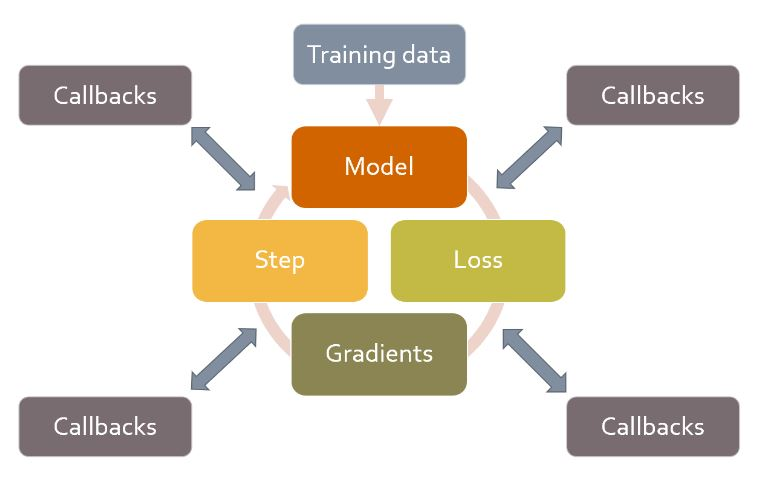

The real effectiveness of this approach has been borne out over the last couple of years—it has turned out that, by using the fastai callback system, we were able to implement every single new paper we tried and fulfilled every user request for modifying the training loop.

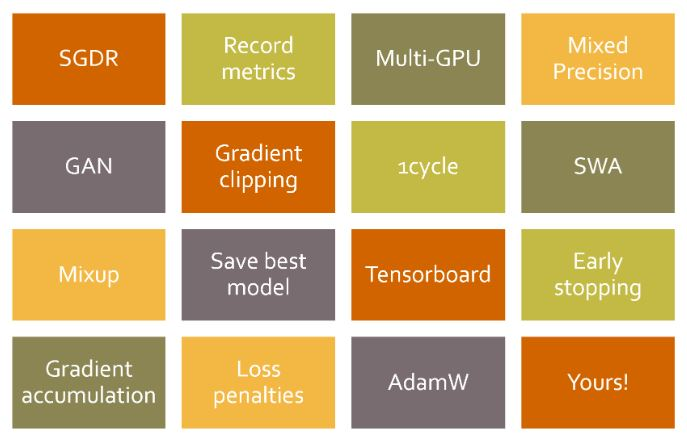

The reason that this is important is because it means that whatever idea we have in our head, we can implement it. We need never dig into the source code of PyTorch or fastai and hack together some one-off system to try out our ideas. And when we do implement our own callbacks to develop our own ideas, we know that they will work together with all of the other functionality provided by fastai–so we will get progress bars, mixed-precision training, hyperparameter annealing, and so forth.

Another advantage is that it makes it easy to gradually remove or add functionality and perform ablation studies. You just need to adjust the list of callbacks you pass along to your fit function.

As an example, here is the fastai source code that is run for each batch of the training loop:



```
try:
    self._split(b);                                  self('before_batch')
    self.pred = self.model(*self.xb);                self('after_pred')
    self.loss = self.loss_func(self.pred, *self.yb); self('after_loss')
    if not self.training: return
    self.loss.backward();                            self('after_backward')
    self.opt.step();                                 self('after_step')
    self.opt.zero_grad()
except CancelBatchException:                         self('after_cancel_batch')
finally:                                             self('after_batch')
```



The calls of the form self('...') are where the callbacks are called. As you see, this happens after every step. The callback will receive the entire state of training, and can also modify it. For instance, the input data and target labels are in self.xb and self.yb, respectively; a callback can modify these to alter the data the training loop sees. It can also modify self.loss, or even the gradients.

Here's the fastai source for the callback that adds RNN regularization 

In [ ]:
class RNNRegularizer(Callback):
    def __init__(self, alpha=0., beta=0.): self.alpha,self.beta = alpha,beta

    def after_pred(self):
        self.raw_out,self.out = self.pred[1],self.pred[2]
        self.learn.pred = self.pred[0]

    def after_loss(self):
        if not self.training: return
        if self.alpha != 0.:
            self.learn.loss += self.alpha * self.out[-1].float().pow(2).mean()
        if self.beta != 0.:
            h = self.raw_out[-1]
            if len(h)>1:
                self.learn.loss += self.beta * (h[:,1:] - h[:,:-1]
                                               ).float().pow(2).mean()

notice how we can access attributes of the training loop by directly checking self.model or self.pred. That's because a Callback will always try to get an attribute it doesn't have inside the Learner associated with it. These are shortcuts for self.learn.model or self.learn.pred. Note that they work for reading attributes, but not for writing them, which is why when RNNRegularizer changes the loss or the predictions you see self.learn.loss = or self.learn.pred =.

# Conclusion

In this chapter we took a close look at the training loop, exploring different variants of SGD and why they can be more powerful. At the time of writing, developing new optimizers is a very active area of research, so by the time you read this chapter there may be an addendum on the book's website that presents new variants. Be sure to check out how our general optimizer framework can help you implement new optimizers very quickly.

We also examined the powerful callback system that allows you to customize every bit of the training loop by enabling you to inspect and modify any parameter you like between each step.